# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [81]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

import time

from torchvision import transforms

In [82]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
torch.cuda.is_available()


True

# Загружаем данные

In [83]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [84]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [85]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [86]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [100]:
def compute_accuracy(model, val_loader):
    """
    Computes accuracy on provided data using mini-batches
    """
    total_samples = 0
    correct_samples = 0

    for i_step, (x, y) in enumerate(val_loader):

        x_gpu = x.to(device)
        y_gpu = y.to(device)
        predictions = model(x_gpu)    
        # print(prediction.shape, y_gpu.shape)
        # https://pytorch.org/docs/master/generated/torch.max.html
        values, indices = torch.max(predictions, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]


    accuracy = int(correct_samples) / total_samples
    return accuracy

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    start = time.time()
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("epoch: %d Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    print("elapsed", time.time() - start, "seconds")
    return loss_history, train_history, val_history
        


In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [88]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

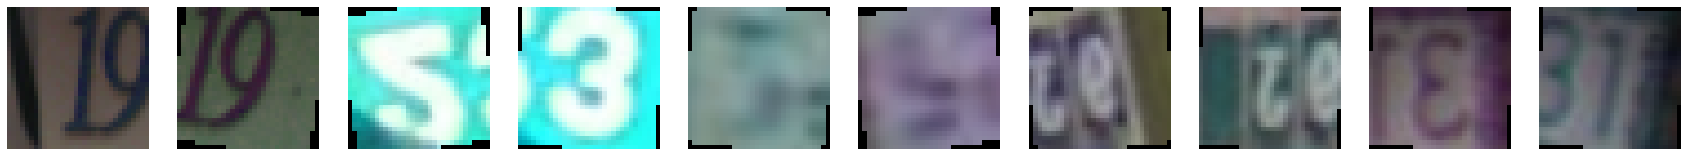

In [89]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

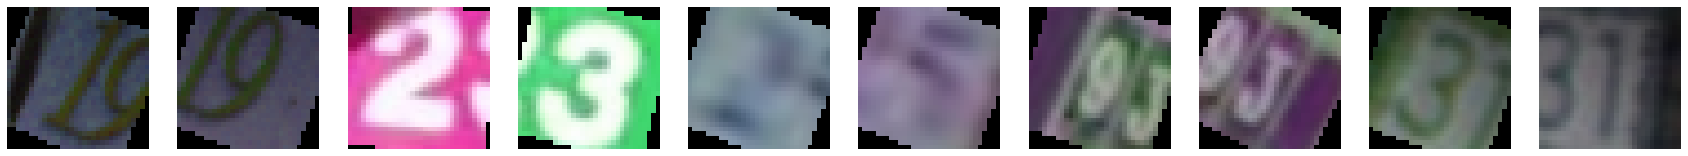

In [90]:
tfs_vis = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(25, resample=PIL.Image.BILINEAR)
])

tfs_aug = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.10),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_vis = dset.SVHN('./data/', 
                       transform=tfs_vis
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

data_aug_train = dset.SVHN('./data/', 
                       transform=tfs_aug
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [91]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

epoch: 0.000000 Average loss: 0.653236, Train accuracy: 0.798997, Val accuracy: 0.818442
epoch: 1.000000 Average loss: 0.595494, Train accuracy: 0.818466, Val accuracy: 0.826838
epoch: 2.000000 Average loss: 0.571317, Train accuracy: 0.826417, Val accuracy: 0.841171
epoch: 3.000000 Average loss: 0.549022, Train accuracy: 0.832253, Val accuracy: 0.845130
epoch: 4.000000 Average loss: 0.541424, Train accuracy: 0.834471, Val accuracy: 0.847382
elapsed 133.40585279464722 seconds


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [92]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            # Flattener(),
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding = 2), #C1
            nn.MaxPool2d(kernel_size = 2), #S2
            nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = 5, padding = 2), #C3
            nn.MaxPool2d(5),    #S4
            nn.Conv2d(in_channels = 16, out_channels = 120,kernel_size = 5, padding = 2), #C5
            Flattener(),
            nn.Linear(in_features=9*120, out_features=84), #F6
            nn.Hardtanh(inplace=True),
            nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-2, weight_decay=1e-3)

In [93]:

# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

epoch: 0.000000 Average loss: 2.158893, Train accuracy: 0.225216, Val accuracy: 0.408163
epoch: 1.000000 Average loss: 1.421220, Train accuracy: 0.535662, Val accuracy: 0.689509
epoch: 2.000000 Average loss: 0.975971, Train accuracy: 0.690356, Val accuracy: 0.767047
epoch: 3.000000 Average loss: 0.828311, Train accuracy: 0.739464, Val accuracy: 0.786772
epoch: 4.000000 Average loss: 0.752342, Train accuracy: 0.764137, Val accuracy: 0.803836
epoch: 5.000000 Average loss: 0.704547, Train accuracy: 0.779784, Val accuracy: 0.815303
epoch: 6.000000 Average loss: 0.666575, Train accuracy: 0.791199, Val accuracy: 0.817828
epoch: 7.000000 Average loss: 0.640914, Train accuracy: 0.800635, Val accuracy: 0.826496
epoch: 8.000000 Average loss: 0.614278, Train accuracy: 0.808023, Val accuracy: 0.824381
epoch: 9.000000 Average loss: 0.598323, Train accuracy: 0.812545, Val accuracy: 0.835233
elapsed 278.5424220561981 seconds


# Подбор гиперпараметров

In [124]:

batch_size = 32

tfs_aug = transforms.Compose([
    transforms.ColorJitter(hue=0, saturation=0),
    transforms.Grayscale(num_output_channels=3),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(2, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./data/', 
                       transform=tfs_aug
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [125]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [ 2e-2]
anneal_coeff = 0.5
anneal_epochs = [25]
weight_decays = [1e-3]

#  Best validation accuracy: 0.75, best hyperparams: Hyperparams(learning_rate=0.02, anneal_epochs=9, reg=0.001, channel1=32, channel2=64, channel3=128, batch_size=32, hue=0, saturation=0, rotation=2)


# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        for num_epoch in anneal_epochs:      
            hyper = Hyperparams(learning_rate , num_epoch, weight_decay)

            model = nn.Sequential(
                        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 2, padding_mode='circular'), #C1
                        nn.MaxPool2d(kernel_size = 3), #S2
                        nn.BatchNorm2d(32),
                        nn.Conv2d(in_channels = 32, out_channels = 64,kernel_size = 5, padding = 2, padding_mode='circular'), #C3
                        nn.MaxPool2d(5),    #S4
                        nn.BatchNorm2d(64),
                        nn.Conv2d(in_channels = 64, out_channels = 128,kernel_size = 5, padding = 2, padding_mode='circular'), #C5
                        nn.BatchNorm2d(128),
                        Flattener(),
                        nn.Linear(in_features=4*128, out_features=64), #F6
                        nn.BatchNorm1d(64),
                        nn.ReLU(inplace=True),
                        nn.Linear(64, 10)
                      )

            
            model.type(torch.cuda.FloatTensor)
            model.to(device)
            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum= 0.6)
            #optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=anneal_coeff)

            loss_history, train_history, val_history = train_model(
                model, train_aug_loader, val_loader, loss, optimizer, num_epochs=num_epoch)

            run = RunResult(model, train_history, val_history, val_history[-1])

            run_record[hyper] = run

epoch: 0 Average loss: 0.807644, Train accuracy: 0.745009, Val accuracy: 0.832093
epoch: 1 Average loss: 0.526560, Train accuracy: 0.837986, Val accuracy: 0.852979
epoch: 2 Average loss: 0.474830, Train accuracy: 0.853735, Val accuracy: 0.853184
epoch: 3 Average loss: 0.436303, Train accuracy: 0.865611, Val accuracy: 0.862057
epoch: 4 Average loss: 0.421880, Train accuracy: 0.871959, Val accuracy: 0.867108
epoch: 5 Average loss: 0.399737, Train accuracy: 0.877419, Val accuracy: 0.867518
epoch: 6 Average loss: 0.390176, Train accuracy: 0.880422, Val accuracy: 0.870794
epoch: 7 Average loss: 0.377739, Train accuracy: 0.884875, Val accuracy: 0.872091
epoch: 8 Average loss: 0.374690, Train accuracy: 0.886189, Val accuracy: 0.877141
epoch: 9 Average loss: 0.369422, Train accuracy: 0.886718, Val accuracy: 0.875981
epoch: 10 Average loss: 0.363124, Train accuracy: 0.888322, Val accuracy: 0.873046
epoch: 11 Average loss: 0.355730, Train accuracy: 0.891837, Val accuracy: 0.876732
epoch: 12 Aver

0.8776192751348031
finished in 856.6298921108246 seconds
Best validation accuracy: 0.88, best hyperparams: Hyperparams(learning_rate=0.02, anneal_epochs=25, reg=0.001)


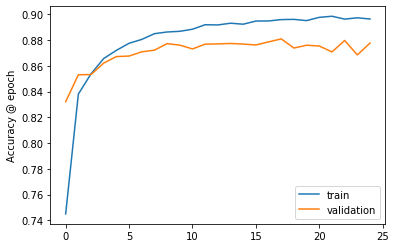

In [126]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    print(run_result.final_val_accuracy)
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("finished in",elapsed,"seconds")        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

import matplotlib.pyplot as plt
def plot_history(train_history, val_history):
    
    # plt.plot(loss_history/np.mean(loss_history))
    plt.ylabel('Accuracy @ epoch')
    
    train, = plt.plot(train_history)
    train.set_label("train")
    validation, = plt.plot(val_history)
    validation.set_label("validation")

    plt.legend()
    plt.show()

plot_history(best_run.train_history, best_run.val_history, )

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [127]:
best_model = best_run.model
#best_model = lenet_model

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [128]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0

# Как всегда, в конце проверяем на test set


test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)

print("lenet accuracy", 0.8417716656422864)
print("Final test accuracy - ", final_test_accuracy)

lenet accuracy 0.8417716656422864
Final test accuracy -  0.8688537185003073
